# Experiment Nine

## Analysis

In [1]:
%load_ext pycodestyle_magic

In [2]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# General Utilities
import json
import pprint
import random

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/hermish/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Reading Data and Defining Constants

In [3]:
FILE_NAMES = [
    'raw-data/questions-and-answers-clean.json',
    'raw-data/judgments.json',
    'raw-data/responses-two.json'
]

NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 7
GROUP_SIZE = NUM_QUESTIONS // 2
THRESHOLD = 240.9

CONDITIONS = ['Control', 'Post Number', 'Upvotes']
QUESTIONS = ['Curiosity', 'Confidence', 'Usefulness',
    'Popularity', 'Writing', 'Surprise', 'Social Utility']

ALL_LABELS = processing.get_all_labels(NUM_QUESTIONS)
LOW_LABELS, HIGH_LABELS = ALL_LABELS[:GROUP_SIZE], ALL_LABELS[GROUP_SIZE:]
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

In [4]:
control_responses = pd.read_pickle('raw-data/control-responses.pkl')
post_responses = pd.read_pickle('raw-data/post-responses.pkl')
upvote_responses = pd.read_pickle('raw-data/upvote-responses.pkl')

upvote_responses.head()
len(post_responses)

161

### Intragroup Low/High Rating T-Tests

In [5]:
for data in (control_responses, post_responses, upvote_responses):
    for j_label in JUDGMENT_LABELS:
        low_headers = ['{}_{}'.format(q_label, j_label) for q_label in LOW_LABELS]
        high_headers = ['{}_{}'.format(q_label, j_label) for q_label in HIGH_LABELS]
        
        low_data = data[low_headers].mean(axis=1)
        high_data = data[high_headers].mean(axis=1)
        
        data['{}_low'.format(j_label)] = low_data
        data['{}_high'.format(j_label)] = high_data
        data['{}_diff'.format(j_label)] = high_data - low_data

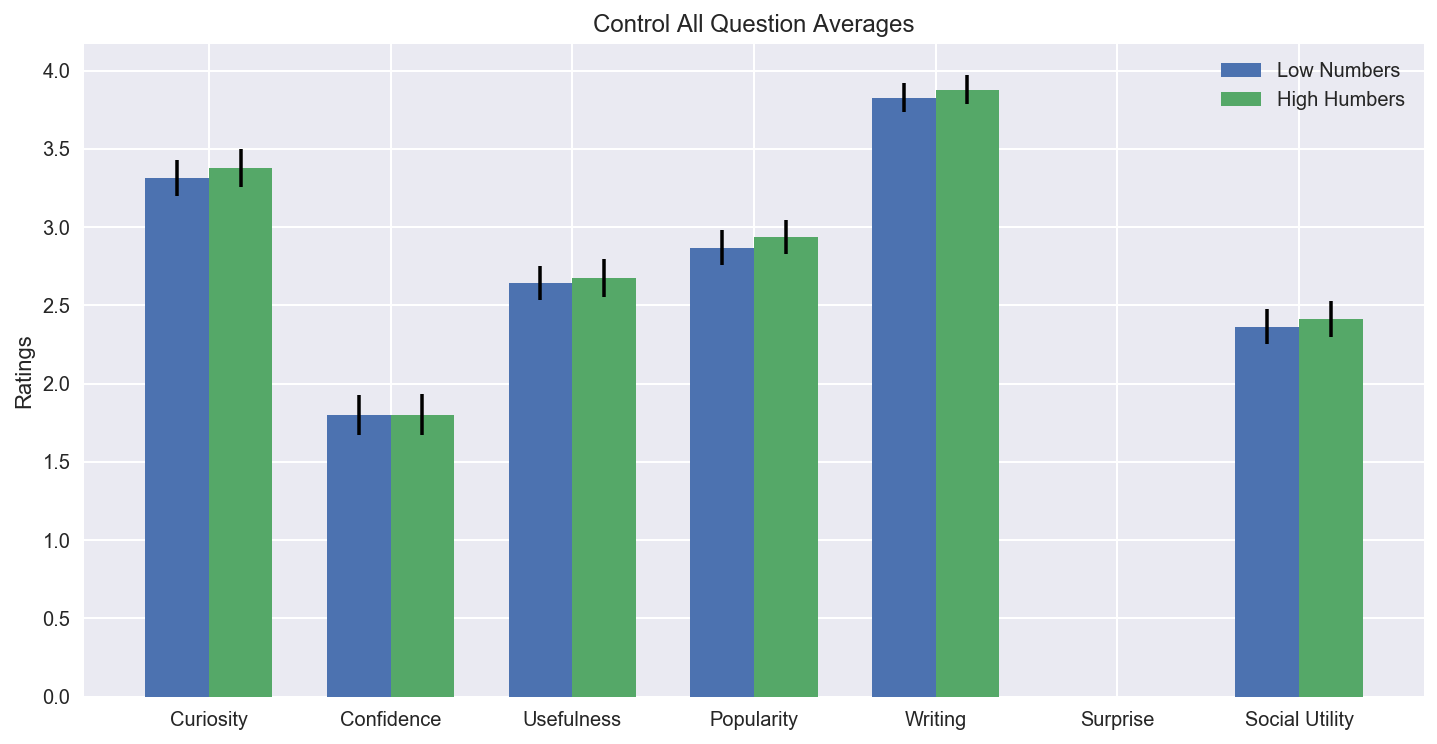

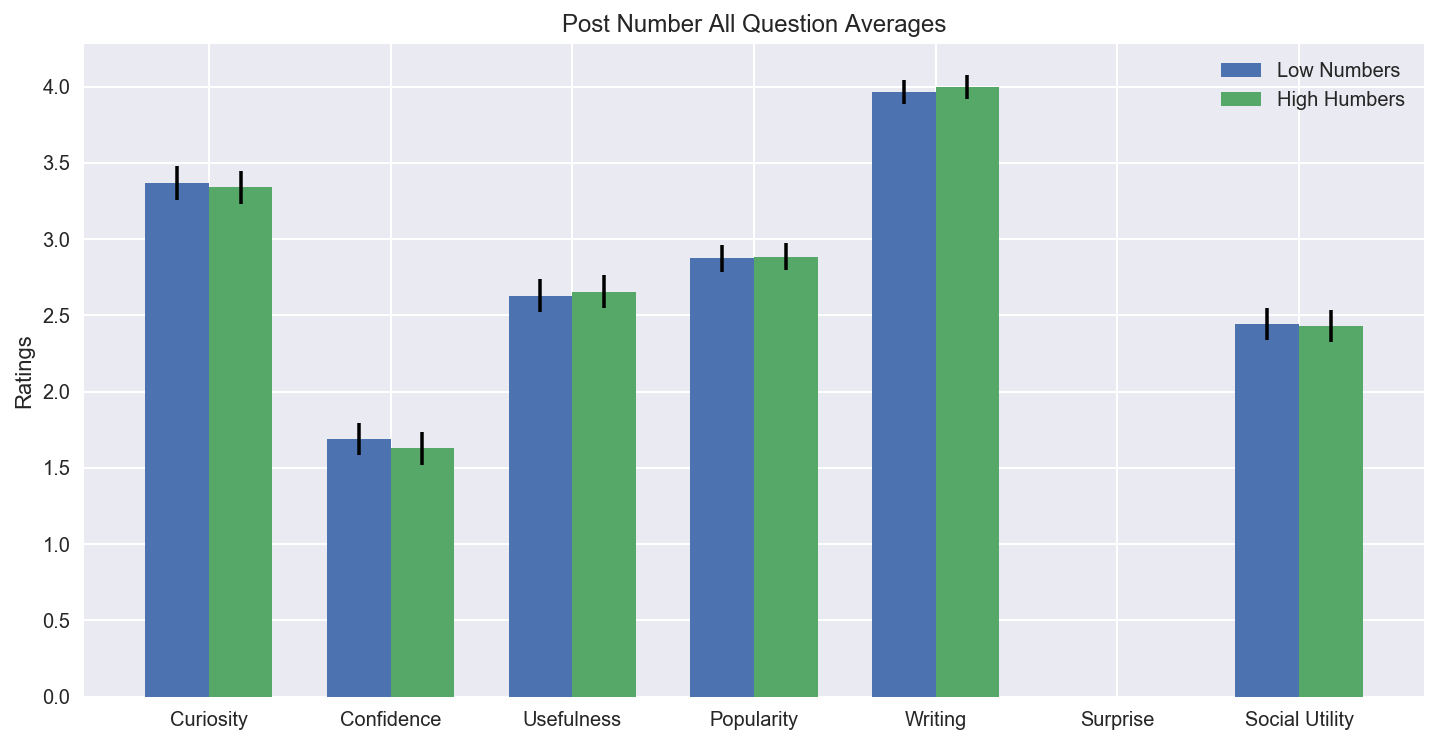

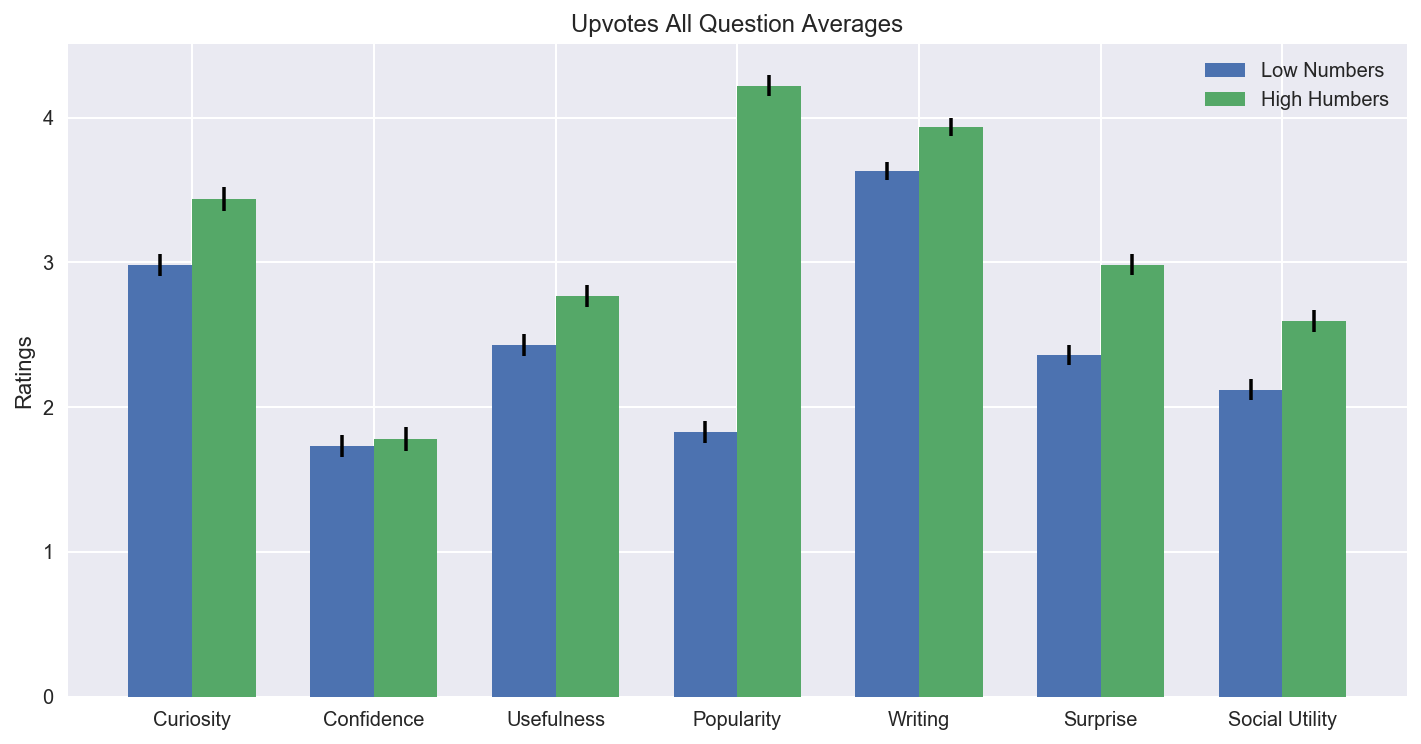

In [6]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility'],
    'legend': ['Low Numbers', 'High Humbers'],
    'size': (12, 6)
}

for name, data in zip(CONDITIONS, (control_responses, post_responses, upvote_responses)):
    low_means, low_errs = [], []
    high_means, high_errs = [], []
    # print(name)
    for j_label in JUDGMENT_LABELS:
        low_data = data['{}_low'.format(j_label)]
        high_data = data['{}_high'.format(j_label)]
        low_means.append(low_data.mean())
        high_means.append(high_data.mean())
        low_errs.append(stats.sem(low_data))
        high_errs.append(stats.sem(high_data))
        # print(low_means); print(high_means)
        # print(low_errs); print(high_errs)
        
    plotting.plot_double_bar(low_means, low_errs, high_means, high_errs,
        **PLOTTING_OPTIONS, title='{} All Question Averages'.format(name))

In [7]:
for name, data in zip(CONDITIONS, (control_responses, post_responses, upvote_responses)):
    print('{}'.format(name))
    for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
        highs = data['{}_high'.format(j_label)]
        lows = data['{}_low'.format(j_label)]
        print('{}: {}, Δ = {:.3f}'.format(
            question,
            describe.paired_t_test(lows, highs),
            highs.mean() - lows.mean()
        ))
    print()

Control
Curiosity: t = -0.752, p = 0.4534 (1 greater), Δ = 0.064
Confidence: t = -0.05913, p = 0.9529 (1 greater), Δ = 0.004
Usefulness: t = -0.408, p = 0.684 (1 greater), Δ = 0.033
Popularity: t = -0.9099, p = 0.3645 (1 greater), Δ = 0.067
Writing: t = -0.7901, p = 0.4309 (1 greater), Δ = 0.052
Surprise: t = nan, p = nan (1 greater), Δ = nan
Social Utility: t = -0.7959, p = 0.4275 (1 greater), Δ = 0.051

Post Number
Curiosity: t = 0.3717, p = 0.7106 (0 greater), Δ = -0.029
Confidence: t = 0.8653, p = 0.3881 (0 greater), Δ = -0.060
Usefulness: t = -0.3145, p = 0.7536 (1 greater), Δ = 0.026
Popularity: t = -0.1595, p = 0.8735 (1 greater), Δ = 0.012
Writing: t = -0.5619, p = 0.575 (1 greater), Δ = 0.032
Surprise: t = nan, p = nan (1 greater), Δ = nan
Social Utility: t = 0.2051, p = 0.8377 (0 greater), Δ = -0.015

Upvotes
Curiosity: t = -7.135, p = 7.465e-12 (1 greater), Δ = 0.455
Confidence: t = -0.8941, p = 0.372 (1 greater), Δ = 0.051
Usefulness: t = -5.588, p = 5.206e-08 (1 greater), 

### Intergroup Difference T-Tests

In [8]:
print('Control & Post Number')
for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
    print('{}: {}'.format(question, describe.independent_t_test(
        control_responses['{}_diff'.format(j_label)],
        post_responses['{}_diff'.format(j_label)])))
print()

print('Control & Upvotes')
for question, j_label in zip(QUESTIONS, JUDGMENT_LABELS):
    print('{}: {}'.format(question, describe.independent_t_test(
        control_responses['{}_diff'.format(j_label)],
        upvote_responses['{}_diff'.format(j_label)])))

Control & Post Number
Curiosity: t = 0.8084, p = 0.4195 (0 greater)
Confidence: t = 0.6263, p = 0.5316 (0 greater)
Usefulness: t = 0.05774, p = 0.954 (0 greater)
Popularity: t = 0.5035, p = 0.615 (0 greater)
Writing: t = 0.2286, p = 0.8193 (0 greater)
Surprise: t = nan, p = nan (1 greater)
Social Utility: t = 0.6656, p = 0.5062 (0 greater)

Control & Upvotes
Curiosity: t = -3.525, p = 0.0004699 (1 greater)
Confidence: t = -0.4683, p = 0.6398 (1 greater)
Usefulness: t = -2.897, p = 0.003964 (1 greater)
Popularity: t = -13.44, p = 1.275e-34 (1 greater)
Writing: t = -2.9, p = 0.003921 (1 greater)
Surprise: t = nan, p = nan (1 greater)
Social Utility: t = -4.614, p = 5.228e-06 (1 greater)


### Intragroup Question Selection

In [9]:
for data in (control_responses, post_responses, upvote_responses):
    low_choice_labels = ['{}_choice'.format(q_label) for q_label in LOW_LABELS]
    high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
    low_choice_means = data[low_choice_labels].mean(axis=1)
    high_choice_means = data[high_choice_labels].mean(axis=1)
    data['low_choice'] = low_choice_means
    data['high_choice'] = high_choice_means

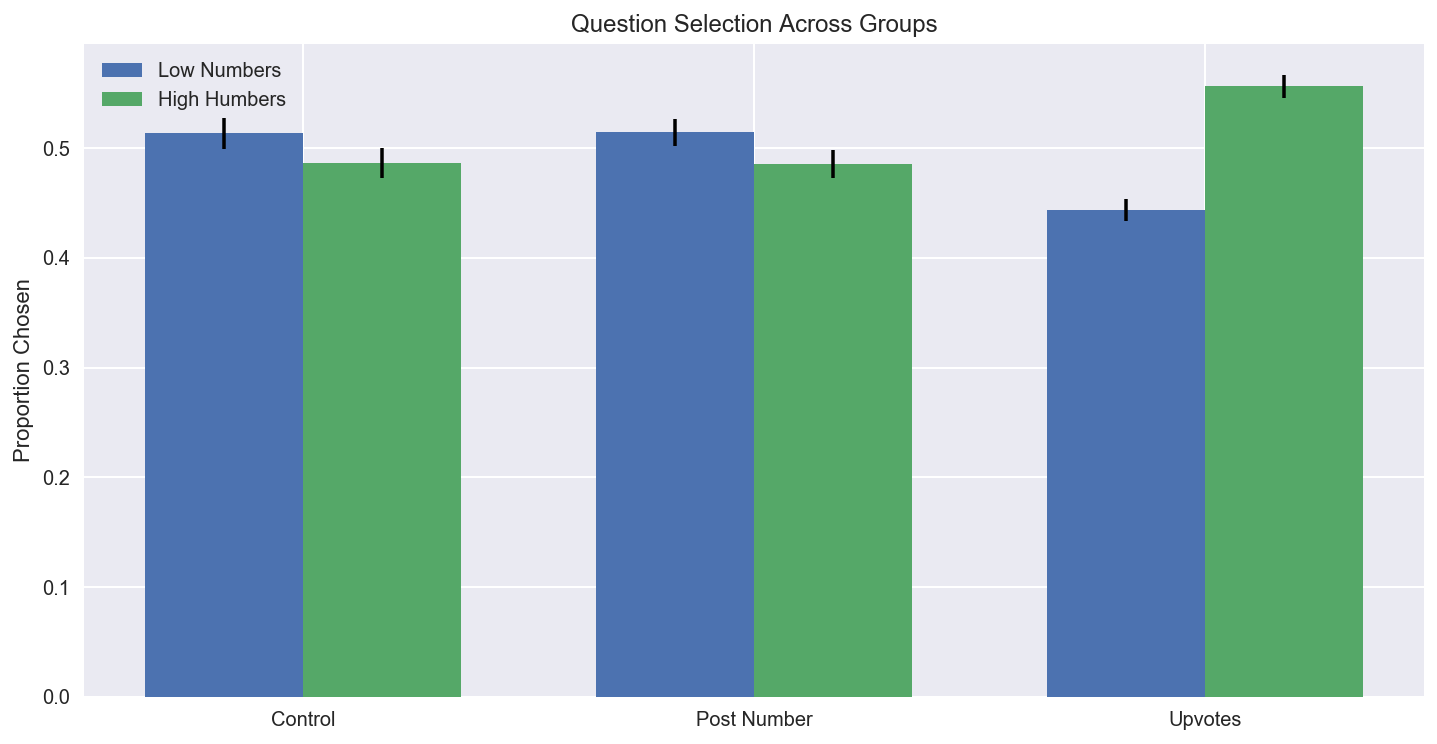

In [10]:
PLOTTING_OPTIONS = {
    'ylabel': 'Proportion Chosen',
    'ticks': ['Control', 'Post Number', 'Upvotes'],
    'legend': ['Low Numbers', 'High Humbers'],
    'size': (12, 6),
    'title': 'Question Selection Across Groups'
}


low_means, low_errs = [], []
high_means, high_errs = [], []
for data in (control_responses, post_responses, upvote_responses):
    low_means.append(data.low_choice.mean())
    high_means.append(data.high_choice.mean())
    low_errs.append(stats.sem(data.low_choice))
    high_errs.append(stats.sem(data.high_choice))

plotting.plot_double_bar(low_means, low_errs, high_means, high_errs,
        **PLOTTING_OPTIONS)

In [11]:
for name, data in zip(CONDITIONS, (control_responses, post_responses, upvote_responses)):
    print('{}: {}, Δ = {:.3}'.format(
        name,
        describe.one_sample_t_test(data.high_choice, 0.5),
        data.high_choice.mean() - 0.5
    ))

Control: t = -0.9731, p = 0.3323 (smaller), Δ = -0.0134
Post Number: t = -1.138, p = 0.2567 (smaller), Δ = -0.0143
Upvotes: t = 5.56, p = 6.026e-08 (greater), Δ = 0.0562


### Per Question Analysis

In [12]:
COLUMN_NAMES = [
    'curiosity', 'confidence', 'usefulness',
    'popularity', 'writing', 'surprise', 'social_utility',
    'group', 'number', 'choice']
flattened_data = {col: [] for col in COLUMN_NAMES}

for index, row in control_responses.iterrows():
    for q_label in ALL_LABELS:
        for number, col_name in enumerate(COLUMN_NAMES[:-3]):
            flattened_data[col_name].append(
                row['{}_j{}'.format(q_label, number)])
    
        choice_info = row['{}_choice'.format(q_label)]
        index_info = row['{}_index'.format(q_label)]
        
        flattened_data['choice'].append(choice_info)
        flattened_data['number'].append(index_info)
        flattened_data['group'].append('base')
        
for index, row in upvote_responses.iterrows():
    for q_num, q_label in enumerate(ALL_LABELS):
        for number, col_name in enumerate(COLUMN_NAMES[:-3]):
            flattened_data[col_name].append(
                row['{}_j{}'.format(q_label, number)])
            
        choice_info = row['{}_choice'.format(q_label)]
        index_info = row['{}_index'.format(q_label)]
        group_info = 'high' if q_num > GROUP_SIZE else 'low'
        
        flattened_data['choice'].append(choice_info)
        flattened_data['number'].append(index_info)
        flattened_data['group'].append('upvote_{}'.format(group_info))
        
for index, row in post_responses.iterrows():
    for q_num, q_label in enumerate(ALL_LABELS):
        for number, col_name in enumerate(COLUMN_NAMES[:-3]):
            flattened_data[col_name].append(
                row['{}_j{}'.format(q_label, number)])
            
        choice_info = row['{}_choice'.format(q_label)]
        index_info = row['{}_index'.format(q_label)]
        group_info = 'high' if q_num > GROUP_SIZE else 'low'
        
        flattened_data['choice'].append(choice_info)
        flattened_data['number'].append(index_info)
        flattened_data['group'].append('post_{}'.format(group_info))

In [13]:
question_data = pd.DataFrame(flattened_data)
print(len(question_data), question_data.size)
question_data.head()

5920 59200


,choice,confidence,curiosity,group,number,popularity,social_utility,surprise,usefulness,writing
0,0.0,0.0,0.0,base,9.0,0.0,0.0,NaN,0.0,0.0
1,1.0,0.0,0.0,base,31.0,0.0,0.0,NaN,0.0,0.0
2,0.0,0.0,0.0,base,37.0,0.0,0.0,NaN,0.0,0.0
3,0.0,0.0,0.0,base,7.0,0.0,0.0,NaN,0.0,0.0
4,1.0,0.0,0.0,base,40.0,0.0,0.0,NaN,0.0,0.0


In [14]:
low_questions = question_data[question_data.group == 'upvote_low']
high_questions = question_data[question_data.group == 'upvote_high']
none_questions = question_data[question_data.group == 'base']

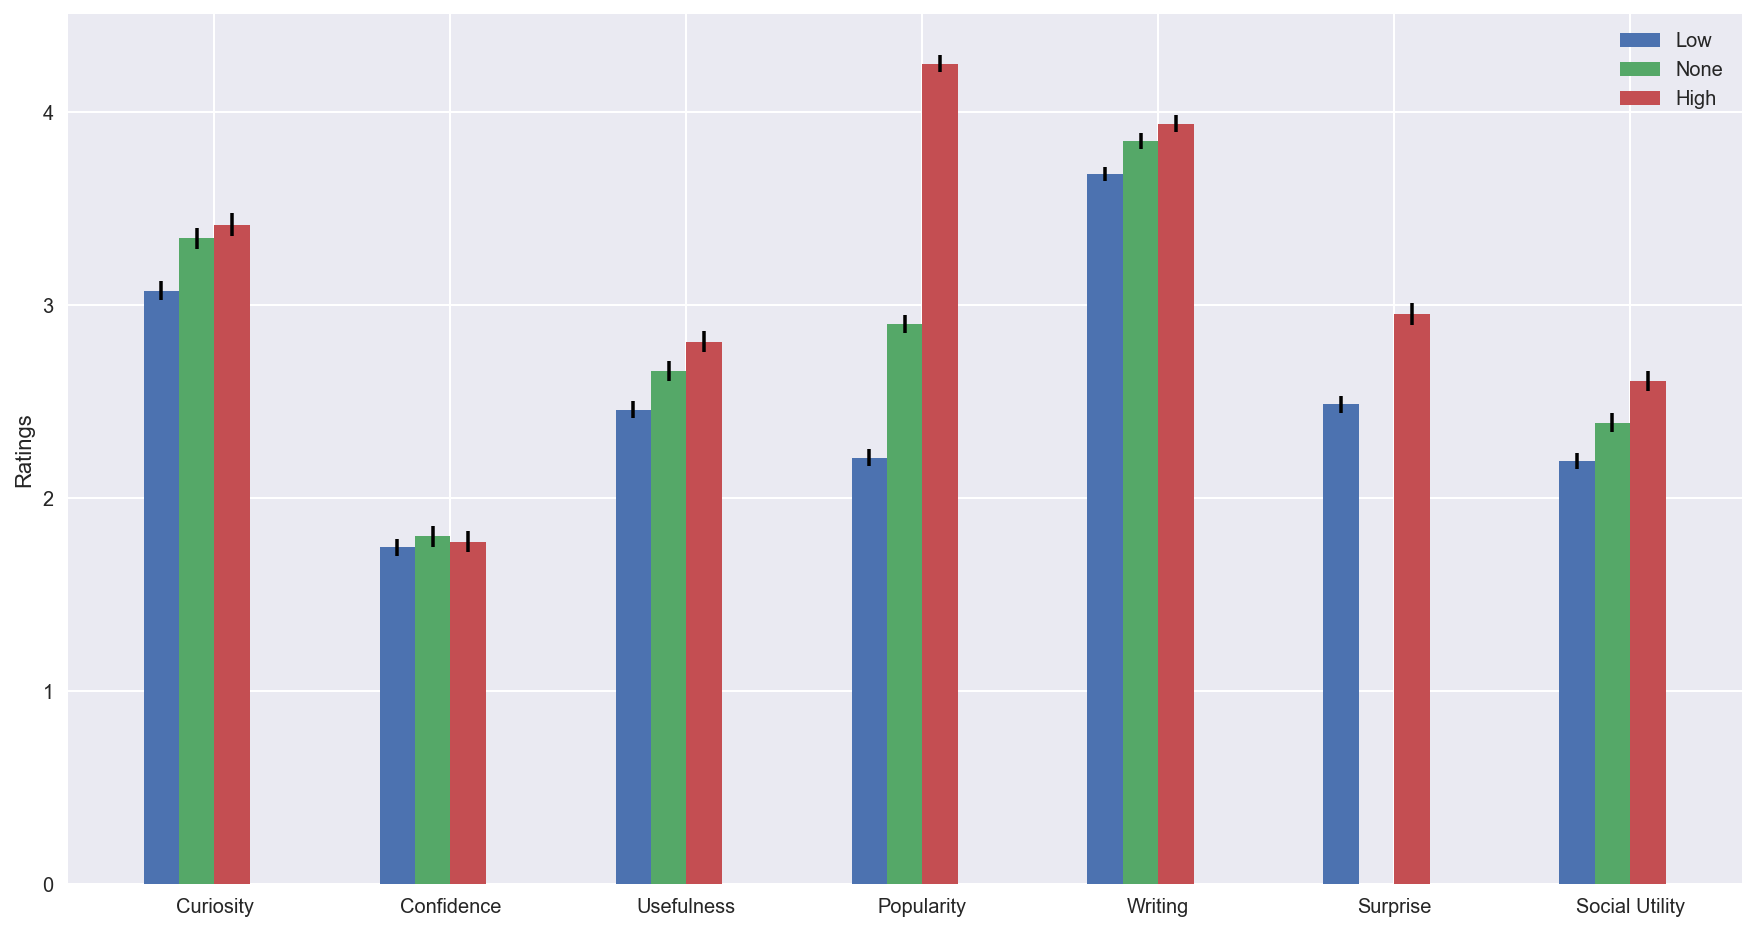

In [15]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility'],
    'legend': ['Low', 'None', 'High'],
    'size': (15, 8)
}

low_means, low_errs = [], []
none_means, none_errs = [], []
high_means, high_errs = [], []

for judgment in COLUMN_NAMES[:7]:
    low_means.append(low_questions[judgment].mean())
    none_means.append(none_questions[judgment].mean())
    high_means.append(high_questions[judgment].mean())
    
    low_errs.append(stats.sem(low_questions[judgment]))
    none_errs.append(stats.sem(none_questions[judgment]))
    high_errs.append(stats.sem(high_questions[judgment]))

plotting.plot_triple_bar(low_means, low_errs, none_means, none_errs, 
                         high_means, high_errs, **PLOTTING_OPTIONS)

In [16]:
INTERESTING = ['curiosity']

low_lower = {label: 0 for label in INTERESTING}
high_higher = {label: 0 for label in INTERESTING}
low_averages = {label: [] for label in INTERESTING}
none_averages = {label: [] for label in INTERESTING}
high_averages = {label: [] for label in INTERESTING}

NUM_DISTINCT_QUESTIONS = 50
for q_number in range(NUM_DISTINCT_QUESTIONS):
    low_related = low_questions[low_questions.number == q_number]
    none_related = none_questions[none_questions.number == q_number]
    high_related = high_questions[high_questions.number == q_number]
    
    for judgment in INTERESTING:
        low_averages[judgment].append(low_related[judgment].mean())
        none_averages[judgment].append(none_related[judgment].mean())
        high_averages[judgment].append(high_related[judgment].mean())
        baseline_judgment = none_related[judgment].mean()
        if baseline_judgment > low_related[judgment].mean():
            low_lower[judgment] += 1
        if baseline_judgment < high_related[judgment].mean():
            high_higher[judgment] += 1

pprint.pprint(low_lower)
pprint.pprint(high_higher)

{'curiosity': 35}
{'curiosity': 27}


### Question Choice Prediction

In [17]:
upvote_question_data = question_data[
    (question_data.group == 'upvote_high') |
    (question_data.group == 'upvote_low')]

In [18]:
all_predictors = [
    'curiosity', 'confidence', 'usefulness', 'popularity',
    'writing', 'surprise', 'social_utility'
]
X = upvote_question_data[all_predictors]
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.616382
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2970
Model:                          Logit   Df Residuals:                     2962
Method:                           MLE   Df Model:                            7
Date:                Sat, 09 Jun 2018   Pseudo R-squ.:                  0.1107
Time:                        18:45:00   Log-Likelihood:                -1830.7
converged:                       True   LL-Null:                       -2058.6
                                        LLR p-value:                 2.302e-94
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1176      0.124     -8.985      0.000      -1.361      -0.874
curiosity          0.3223      0.027     11.755      0.000       0.269       0.376
confidence        -0.0910      0.023     -3.906      0.000      -0.137      -0.045
usefulness         0.1083      0.034      3.226      0.001       0.042       0.174
popularity         0.0779      0.022      3.512      0.000       0.034       0.121
writing           -0.0072      0.028     -0.254      0.799      -0.063       0.049
surprise          -0.0944      0.022     -4.317      0.000      -0.137      -0.052
social_utility     0.0011      0.034      0.033      0.974      -0.066       0.069
==================================================================================
"""

### Mediation of Popularity by Curiousity in Question Choice

In [19]:
# Popularity
X = upvote_question_data['popularity']
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
display(results.summary())

# Curiosity
X = upvote_question_data['curiosity']
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
display(results.summary())

# Both
X = upvote_question_data[['popularity', 'curiosity']]
y = upvote_question_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
display(results.summary())

Optimization terminated successfully.
         Current function value: 0.678059
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2970
Model:                          Logit   Df Residuals:                     2968
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Jun 2018   Pseudo R-squ.:                 0.02177
Time:                        18:45:00   Log-Likelihood:                -2013.8
converged:                       True   LL-Null:                       -2058.6
                                        LLR p-value:                 2.877e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5261      0.068     -7.787      0.000      -0.659      -0.394
popularity     0.1739      0.019      9.345      0.000       0.137       0.210
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.625531
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2970
Model:                          Logit   Df Residuals:                     2968
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Jun 2018   Pseudo R-squ.:                 0.09755
Time:                        18:45:00   Log-Likelihood:                -1857.8
converged:                       True   LL-Null:                       -2058.6
                                        LLR p-value:                 2.419e-89
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2549      0.078    -16.035      0.000      -1.408      -1.102
curiosity      0.3881      0.021     18.793      0.000       0.348       0.429
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.624036
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2970
Model:                          Logit   Df Residuals:                     2967
Method:                           MLE   Df Model:                            2
Date:                Sat, 09 Jun 2018   Pseudo R-squ.:                 0.09971
Time:                        18:45:00   Log-Likelihood:                -1853.4
converged:                       True   LL-Null:                       -2058.6
                                        LLR p-value:                 7.193e-90
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3768      0.089    -15.465      0.000      -1.551      -1.202
popularity     0.0620      0.021      2.986      0.003       0.021       0.103
curiosity      0.3677      0.022     17.000      0.000       0.325       0.410
==============================================================================
"""

### Correlations

In [20]:
print(
    stats.pearsonr(
        upvote_question_data.curiosity,
        upvote_question_data.surprise),
    stats.pearsonr(
        upvote_question_data.curiosity,
        upvote_question_data.social_utility),
    stats.pearsonr(
        upvote_question_data.curiosity,
        upvote_question_data.usefulness),
)

(0.13050424014217601, 9.3506961009442868e-13) (0.55900151055663128, 8.8482219890515626e-244) (0.61338334946559836, 1.5296579934846479e-306)


### Saving Data

In [21]:
upvote_responses.to_pickle('raw-data/exp_two_responses.pkl')